## Exploring data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import hydroeval as he
from tensorflow import keras
import hydroeval as he

In [8]:
df_b = pd.read_csv("data/basel.csv", index_col=0)
df_b.head()

,datetime,et,p,t,obs
0,1981-01-01,0.000405,0.003536,-0.250816,670.0
1,1981-01-02,0.000472,0.003379,2.172385,647.0
2,1981-01-03,0.000576,0.017352,5.165919,727.0
3,1981-01-04,0.000443,0.022734,1.019687,1363.0
4,1981-01-05,0.000364,0.005195,-2.055391,1202.0


In [9]:
df_b.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
et,7305.0,0.001714,0.001106,0.000174,0.000699,0.001463,0.002551,0.005657
p,7305.0,0.004003,0.006059,0.000000,0.000000,0.001118,0.005937,0.064737
t,7305.0,7.407180,7.137879,-21.928990,2.108310,7.466198,13.141790,25.095398
obs,7305.0,1089.771141,460.346002,393.000000,751.000000,1003.000000,1332.000000,4583.996000


In [10]:
q_basel = pd.read_csv("data/q_basel.csv")
q_basel = q_basel.drop(["obs"], axis =1)
q_basel = q_basel.set_index("datetime")
q_basel

,pcr,res
datetime,,
1981-01-01,605.06915,64.93085
1981-01-02,599.35767,47.64233
1981-01-03,874.38354,-147.38354
1981-01-04,998.86804,364.13196
1981-01-05,968.06270,233.93730
...,...,...
2000-12-27,1055.62610,-393.59110
2000-12-28,1027.90730,-371.65430
2000-12-29,860.76306,-208.61306


In [11]:
# make the date column index
df_basel = df_b.set_index("datetime")
df_basel.shape

(7305, 4)

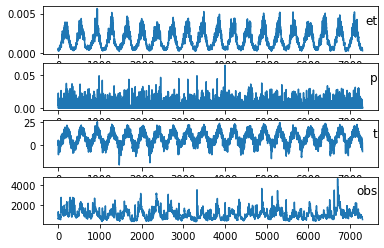

In [12]:
from matplotlib import pyplot
values = df_basel.values

# specify columns to plot
groups =[0,1,2,3]
i=1
# plot each column
pyplot.figure()
for g in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, g])
    pyplot.title(df_basel.columns[g], y= 0.5, loc ="right")
    i += 1
pyplot.show()



## LSTM data prepration

In [13]:
# a function that, given the initial dataframe, return a shorter dataframe sequence of length.
# This shorter sequence should be selected at random.

from numpy.random import seed
seed(1)
def subsample_sequence(df, length):

    last_possible = df.shape[0] - length

    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]

    return df_sample

In [14]:
# a function to deal with nan values
def fillna(X, df_mean):

    na = X.mean()

    na.fillna(df_mean)
    return na

# a function that given a full dataframe, first subsample this dataset into a shorter sequence,
# and then splits the shorter dataframe into a training sequence and a value to predict.

def split_subsample_sequence(df, length, df_mean=None):
    # Little trick to improve the time
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    if set(["pcr","res"]).issubset(df_subsample.columns):
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['pcr']
    else:
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['obs']

    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(df, length, df_mean)
        return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:df_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, df_mean))
    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [15]:
# another function that generates an entire dataset of multiple subsamples,
# given an initial dataframe df, a number of desired sequences, and a length for each sequence

def get_X_y(df, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [16]:
# train test split
len_ = int(0.75 *df_basel.shape[0])

df_train = df_basel[:len_]
df_test = df_basel[len_:]

In [17]:
# time window based on  insight gained from ccf function in R is equal to 50
from numpy.random import seed
seed(1)
X_train, y_train = get_X_y(df_train, 2000, 51) # The training set correspond to 1000 sequences, each of size 50 (+ the time to predict)
X_test, y_test = get_X_y(df_test, 731, 51)


In [18]:
# dropping "obs" var from predictors in train set
X_train_new = [np.delete(X,-1, axis =1) for X in X_train]
X_train_ready = np.asarray(X_train_new)
X_train_ready.shape

(2000, 50, 3)

In [19]:
# dropping "obs" var from predictors in test set
X_test_new = [np.delete(X,-1, axis = 1) for X in X_test]
X_test_ready = np.asarray(X_test_new)
X_test_ready.shape

(731, 50, 3)

## Normalizing data

In [20]:
# https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_ready.reshape(-1, X_train_ready.shape[-1])).reshape(X_train_ready.shape)
X_test_scaled = scaler.transform(X_test_ready.reshape(-1, X_test_ready.shape[-1])).reshape(X_test_ready.shape)


In [21]:
# normalize output
y_train_shaped = np.reshape(y_train, (y_train.shape[0], 1))

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train_shaped)
# y_train_scaled[0]

y_test_shaped = np.reshape(y_test, (y_test.shape[0], 1))

y_test_scaled = scaler.transform(y_test_shaped)
y_test_scaled.shape

(731, 1)

## Hyperparameter Optimization

In [22]:
# START WITH FINETUNE NOTEBOOK ADD THE BASE MODEL DESCRIBED THERE MAYBE

# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
# https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb
# the ANN note book
# https://www.kaggle.com/code/rendyk/neural-network-hyperparameter-tuning/notebook
# https://keras.io/keras_tuner/

In [23]:
# define the baseline model

import keras_tuner as kt
from tensorflow import keras


## ADD lR SEARCH TO IT ##
def build_baseline_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train_scaled.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu')))
    #model.compile(loss='mean_squared_error', optimizer=('adam'),metrics = ['mse'])
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[0.01, 0.001])), metrics = ['mse'])
    return model


In [24]:
# instantiate the Hyperband tuner

tuner = kt.Hyperband(build_baseline_model,
                     overwrite=True,
                     objective='mse',
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations = 2,
                     directory='hyperparameter_tunning',
                     project_name='LSTM_Basel_hyperparameter_tunning')



In [25]:
# create a callback to stop training early after reaching a certain value for the validation loss.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# run the tuner
tuner.search(X_train_scaled, y_train_scaled, epochs=25, validation_split=0.2, callbacks=[es])

#get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]


Trial 60 Complete [00h 04m 28s]
mse: 0.0067629460245370865

Best mse So Far: 0.006018669810146093
Total elapsed time: 06h 04m 20s
INFO:tensorflow:Oracle triggered exit


In [31]:
# https://keras.io/api/keras_tuner/tuners/base_tuner/#getbesthyperparameters-method
model = tuner.hypermodel.build(best_hps)


In [32]:
tuner.get_best_models(num_models=1)

In [33]:
tuner.results_summary(num_trials=2)

Results summary
Results in hyperparameter_tunning\LSTM_Basel_hyperparameter_tunning
Showing 2 best trials
Trial summary
Hyperparameters:
input_unit: 128
n_layers: 3
lstm_0_units: 256
layer_2_neurons: 128
Dropout_rate: 0.2
dense_activation: tanh
learning_rate: 0.001
lstm_1_units: 320
lstm_2_units: 448
lstm_3_units: 448
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.006018669810146093
Trial summary
Hyperparameters:
input_unit: 416
n_layers: 2
lstm_0_units: 160
layer_2_neurons: 160
Dropout_rate: 0.1
dense_activation: tanh
learning_rate: 0.001
lstm_1_units: 160
lstm_2_units: 160
lstm_3_units: 64
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.006275287829339504


## Model

In [35]:
%%time
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled,
            validation_split=0.2,
            epochs=1000,
            batch_size= 32, # try it with 16| 128  | 512
            callbacks=[es])

Epoch 1/1000
50/50 [==============================] - 71s 1s/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 2/1000
50/50 [==============================] - 62s 1s/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 3/1000
50/50 [==============================] - 63s 1s/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 4/1000
50/50 [==============================] - 59s 1s/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 5/1000
50/50 [==============================] - 62s 1s/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 6/1000
50/50 [==============================] - 68s 1s/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 7/1000
50/50 [==============================] - 78s 2s/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 8/1000
50/50 [==============================] - 64s 1s/step - loss: 0.

In [36]:
# UNITS are related to the shape of output?
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50, 128)           67584     
                                                                 
 lstm_6 (LSTM)               (None, 50, 256)           394240    
                                                                 
 lstm_7 (LSTM)               (None, 50, 320)           738560    
                                                                 
 lstm_8 (LSTM)               (None, 50, 448)           1378048   
                                                                 
 lstm_9 (LSTM)               (None, 128)               295424    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

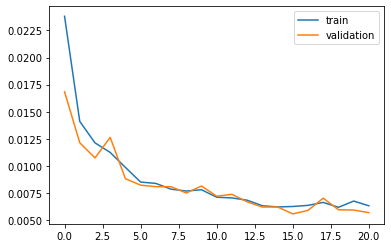

In [37]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

# why test loss is less than train loss: https://www.researchgate.net/post/Tuning_hyperparameters_for_LSTM_Neural_Network

## Evaluation

In [38]:
res = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0098


In [39]:
y_pred = model.predict(X_test_scaled)

nse = he.evaluator(he.nse,y_pred,y_test_scaled)
nse[0]

0.6615509333444696

In [40]:
# How to Train a Final Machine Learning Model:  https://machinelearningmastery.com/train-final-machine-learning-model/
kge = he.evaluator(he.kge, y_pred, y_test_scaled)
kge[0]

array([0.65426255])

### Saving model

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [43]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [47]:
# evaluate loaded model on test data
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loaded_model.compile(loss='mean_squared_error',optimizer= optimizer , metrics = ['mse'])
score = loaded_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0098


## Dealing with randomness

In [81]:
%%time
def train_multiple_times():
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
    model.fit(X_train_scaled, y_train_scaled,
            validation_split=0.2,
            epochs=1000,
            batch_size= 32,
            callbacks=[es])
    y_pred = model.predict(X_test_scaled)
    # invert predictions
    y_pred_inversed = scaler.inverse_transform(y_pred)


    nse = he.evaluator(he.nse,y_pred,y_test_scaled)
    kge = he.evaluator(he.kge, y_pred, y_test_scaled)
    return (nse, kge[0], y_pred_inversed)


nse = []
kge = []
y_pred = []
repeats = 30

for t in range(repeats):

    nse_multiple, kge_multiple, y_pred_inversed = train_multiple_times()
    nse.append(nse_multiple)
    kge.append(kge_multiple)
    y_pred.append(y_pred_inversed)

    print(f'For {t} time running model, the NSE is : {nse_multiple}')
    print(f'For {t} time running model, the KGE is : {kge_multiple}')

Epoch 1/1000
50/50 [==============================] - 70s 1s/step - loss: 2.5046e-04 - mse: 2.5046e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 2/1000
50/50 [==============================] - 71s 1s/step - loss: 2.8219e-04 - mse: 2.8219e-04 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 3/1000
50/50 [==============================] - 70s 1s/step - loss: 2.6700e-04 - mse: 2.6700e-04 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 4/1000
50/50 [==============================] - 71s 1s/step - loss: 3.8397e-04 - mse: 3.8397e-04 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/1000
50/50 [==============================] - 71s 1s/step - loss: 4.2574e-04 - mse: 4.2574e-04 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/1000
50/50 [==============================] - 76s 2s/step - loss: 3.8937e-04 - mse: 3.8937e-04 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/1000
50/50 [==============================] - 76s 2s/step - loss: 6.6389e-04 - mse: 6.6389e-04 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7: early stopp

In [86]:
# convert y_pred to an array
y_pred_array = np.array(y_pred)

# dimension of y_pred array
y_pred_array.shape

(30, 731, 1)

In [97]:
# taking the mean of y_pred and reading it in a csv file
y_df = pd.DataFrame(y_pred_array.mean(axis=0))

# changing the name of the file
y_df.columns = ["y_pred"]

# saving the calculated mean to a csv file
y_df.to_csv("y_pred.csv")

In [99]:
# double-check the mean of y_pred with another technique
np.save("y_pred_30_2.npy", y_pred_array, allow_pickle=True)
y_pred_loaded = np.load('y_pred_30_2.npy', allow_pickle=True)
y_pred_loaded.shape

(30, 731, 1)

In [137]:
# comapre the means
y_pred_loaded.mean(axis=0)[:10]

array([[1525.6908 ],
       [1363.6954 ],
       [1111.0657 ],
       [1269.9675 ],
       [1309.0736 ],
       [1720.2632 ],
       [1068.4448 ],
       [ 983.95   ],
       [ 905.62305],
       [1065.2257 ]], dtype=float32)

In [142]:
# save NSE

# nse = np.array(nse)
# np.save('nse_basel_ave_30_2.npy', nse, allow_pickle=True)

# best so far is nse_basel_3
nse_loaded = np.load('nse_basel_ave_30_2.npy',allow_pickle=True)

# means and sd of NSE
nse_mean = np.mean(nse_loaded)
nse_sd = np.std(nse_loaded)
print(f'mean NSE is : {nse_mean}')
print(f'Standard devation of NSE is : {nse_sd}')

mean NSE is : 0.6225401169956385
Standard devation of NSE is : 0.009512174595845389


In [145]:
# save KGE
# hypertunned model nse with _ave in the name

# kge = np.array(kge)
# np.save('kge_basel_ave_30_2.npy', kge, allow_pickle=True)

kge_loaded = np.load('kge_basel_ave_30_2.npy',allow_pickle=True)

# means and sd of KGE
kge_mean = np.mean(kge_loaded)
kge_sd = np.std(kge_loaded)
print(f'mean KGE is : {kge_mean}')
print(f'Standard deviation of KGE is : {kge_sd}')

mean KGE is : 0.6744216328498004
Standard deviation of KGE is : 0.010362079579937239


## Prediction

In [140]:
# https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

Y_df = pd.read_csv("y_pred.csv")
Y_pred = Y_df.y_pred.values
Y_test = scaler.inverse_transform(y_test_scaled)


## Plots

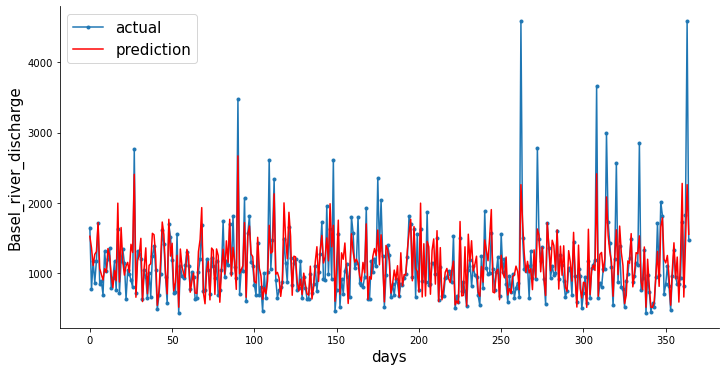

In [118]:
# comparing actual and predicted values for the last 356 days
import seaborn as sns
aa=[x for x in range(365)]
plt.figure(figsize=(10,5))
plt.plot(aa, Y_test[:365], marker='.', label="actual")
plt.plot(aa, Y_pred[:365], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Basel_river_discharge', size=15)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [132]:
# https://stackoverflow.com/questions/43702481/why-does-keras-lstm-batch-size-used-for-prediction-have-to-be-the-same-as-fittin :Why does Keras LSTM batch size used for prediction have to be the same as fitting batch size?

# getting the result of pcr model
pcr_pred = q_basel.pcr.values[len_:]

# train-test split
len_ = int(0.75*q_basel.shape[0])

df_train_pcr = q_basel[:len_]
df_test_pcr = q_basel[len_:]

# making data in right shape
pcr_X_train, pcr_y_train = get_X_y(df_train_pcr, 2000, 51)
pcr_X_test, pcr_y_test = get_X_y(df_test_pcr, 731, 51)

# normalize pcr_observation
pcr_y_test_reshaped = np.reshape(pcr_y_test, (pcr_y_test.shape[0], 1))

scaler = MinMaxScaler()
pcr_y_test_scaled = scaler.fit_transform(pcr_y_test_reshaped)

# nse for pcr
nse_pcr = he.evaluator(he.nse, pcr_y_test_scaled, y_test_scaled)
nse_pcr

array([-0.65797519])

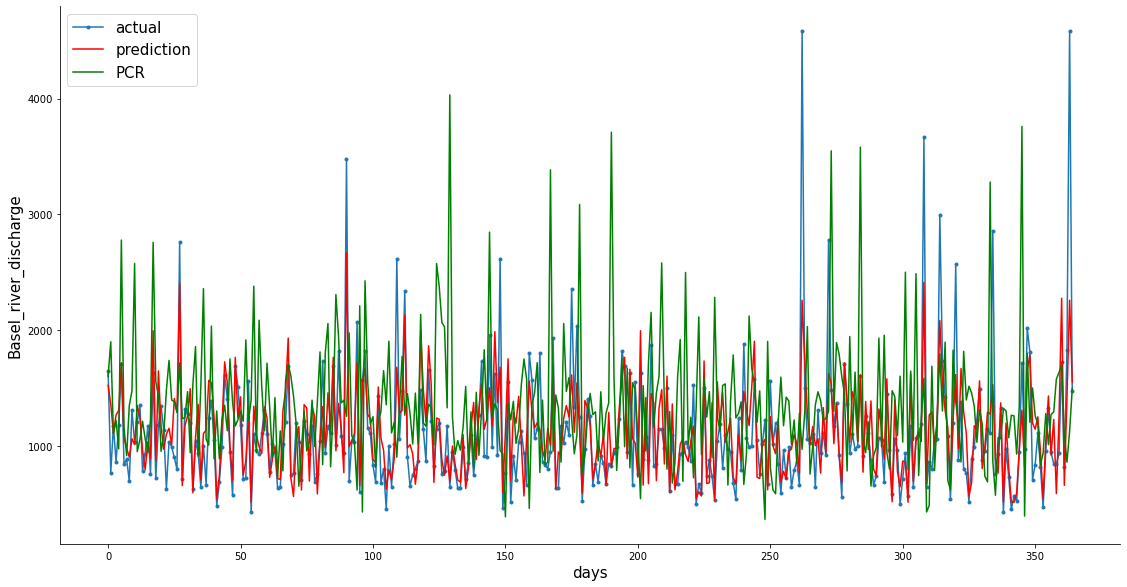

In [133]:
aa=[x for x in range(365)]
plt.figure(figsize=(16,8))
plt.plot(aa, Y_test[:365], marker='.', label="actual")
plt.plot(aa, Y_pred[:365], 'r', label="prediction")
plt.plot(aa, pcr_y_test [:365], "green", label ="PCR" )
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Basel_river_discharge', size=15)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [134]:
#define a smoothing function
def smooth_fun(y, window):
  new_len = len(y)//window
  smooth_y = np.zeros((new_len))
  for i in range(new_len):
    smooth_y[i] = np.mean(y[i*window:i*window+window])
  return smooth_y

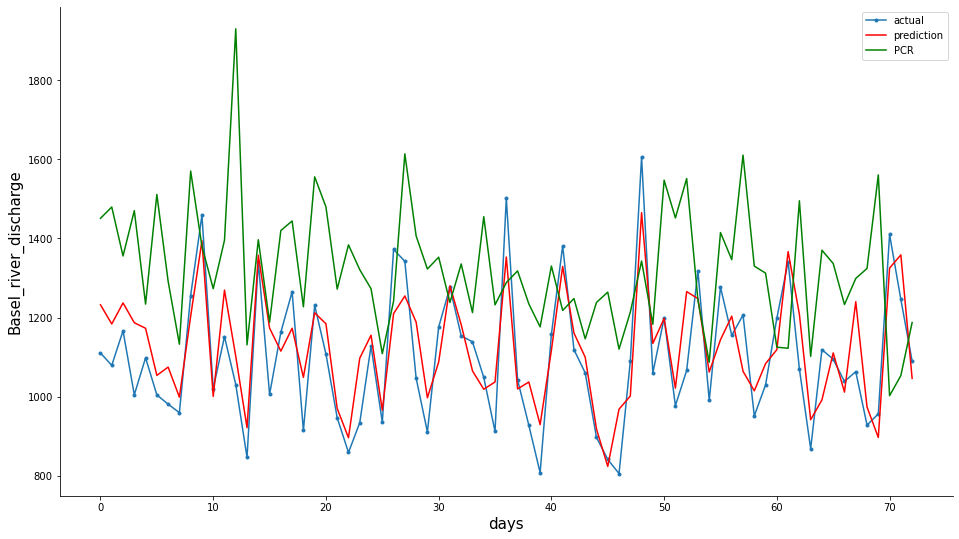

In [135]:
#plot smoothed predictions
plt.figure(figsize = (16,9))
plt.plot(smooth_fun(Y_test, 10),marker='.', label = "actual")
plt.plot(smooth_fun(Y_pred, 10),"r", label = "prediction")
plt.plot(smooth_fun(pcr_y_test,10),"g", label = "PCR")
plt.ylabel('Basel_river_discharge', size=15)
plt.xlabel('days', size=15)
sns.despine(top=True)
# plt.subplots_adjust(left=0.07)

plt.legend()
plt.show()

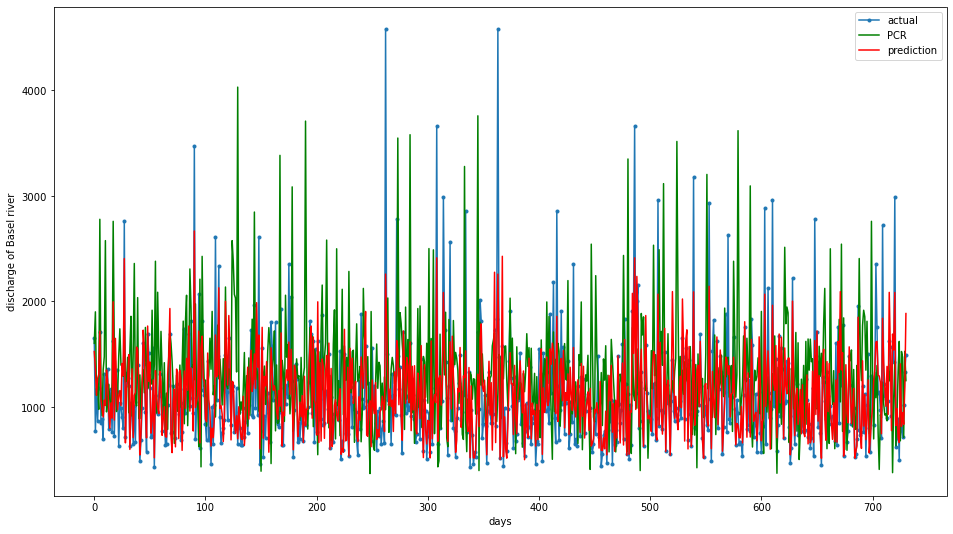

In [136]:
# make a plot of observed dicharge, prediction of model, prediction of pcr for the last 2 years
plt.figure(figsize=(16,9))
plt.plot(Y_test[:731], marker='.', label="actual")
plt.plot(pcr_y_test [:731], 'green', label="PCR")
plt.plot(Y_pred, 'r', label="prediction")
plt.xlabel('days')
plt.ylabel('discharge of Basel river')
plt.legend()

## A random model

In [106]:
%%time
# from numpy.random import seed
# seed(1)
# tf.random.set_seed(1234)

def init_model():

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True)) # input shape?? input_shape =(X_train_scaled.shape[1],3)
    model.add(Dropout(0.2)) # decrease this
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1,activation='linear')) # activation = linear

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])

    return model



model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_scaled,
            validation_split=0.2,
            epochs=1000,
            batch_size= 32, # try it with 16| 128 = 0.0687 | 512 = 0.705
            callbacks=[es])

Epoch 1/1000
50/50 [==============================] - 15s 157ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 2/1000
50/50 [==============================] - 7s 134ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 3/1000
50/50 [==============================] - 6s 125ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 4/1000
50/50 [==============================] - 6s 127ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 5/1000
50/50 [==============================] - 7s 134ms/step - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 6/1000
50/50 [==============================] - 7s 145ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 7/1000
50/50 [==============================] - 7s 147ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 8/1000
50/50 [==============================] - 7s 145m

In [108]:
print(model.input_shape, model.output_shape) # None is a placeholder of batch size

(None, 50, 3) (None, 1)


In [109]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50, 50)            10800     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_3 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)               

## Evaluation

In [110]:
res = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0125


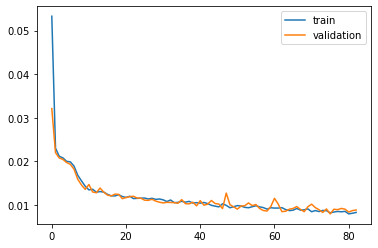

In [111]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [112]:

y_pred = model.predict(X_test_scaled)

nse = he.evaluator(he.nse,y_pred,y_test_scaled)
nse[0]


0.5714193210091113

In [113]:
# How to Train a Final Machine Learning Model:  https://machinelearningmastery.com/train-final-machine-learning-model/
kge = he.evaluator(he.kge, y_pred, y_test_scaled)
kge[0]

array([0.57987308])